In [13]:
import random
import torch
import cv2
import re
import supervision as sv
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from pathlib import Path
from ultralytics import YOLO
from collections import defaultdict
from PIL import Image
from tqdm.auto import tqdm

In [25]:
MODEL_PATH = Path("../../runs/detect/train4/weights/best.pt")
SAM2_CHECKPOINT = "segment-anything-2-real-time/checkpoints/sam2.1_hiera_large.pt"
SAM2_CONFIG = "segment-anything-2-real-time/configs/sam2.1/sam2.1_hiera_l.yaml"


VAL_IMAGES_DIR = Path("../../data/tracking/YOLO/images/val")
VIDEO_OUT_DIR = Path("../../videos")
VIDEO_OUT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Tracking

Usé 2 formas hasta ahora:

- La primera es con el método de `update_with_detections` de supervision, es un tracker que se monta encima de YOLO. Inferís con YOLO frame a frame y el tracker le asigna un ID y los sigue.

- La segunda ya es otra cosa, es con SAM. Hacés lo siguiente: Agarrás el primer frame y detectas todo con YOLO, después le pasas eso como promt a SAM y el modelo se encarga de trackearlos. **El gran roblema**: cuando aparecen o desaparecen jugadores del frame, SAM los pierde completamente y se va todo a la mierda

## Levanto el modelo

(Todo esto es general a ambos métodos)

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = YOLO(str(MODEL_PATH))
model.to(device)
print("Loaded model from:", MODEL_PATH)

names = model.names  
print("Classes:", names)

Using device: cuda
Loaded model from: ../../runs/detect/train4/weights/best.pt
Classes: {0: 'player', 1: 'referee', 2: 'ball', 3: 'goalkeeper'}


## Elegir un clip random

In [16]:
pat = re.compile(r"SNMOT-(\d+)_(\d+)\.jpg$")
clip_to_frames = defaultdict(int)

for p in Path(VAL_IMAGES_DIR).glob("SNMOT-*_*.jpg"):
    m = pat.match(p.name)
    if m:
        clip_id = int(m.group(1))
        clip_to_frames[clip_id] += 1

clip_ids = sorted(clip_to_frames.keys())
print(f"Found {len(clip_ids)} clips in {VAL_IMAGES_DIR}")
print("All clip IDs:")
print(clip_ids)

if not clip_ids:
    raise FileNotFoundError(f"No SNMOT-{{clip}}_{{frame}}.jpg files found in {VAL_IMAGES_DIR}")

CLIP_ID = random.choice(clip_ids)
print(f"Randomly selected existing CLIP_ID = {CLIP_ID}  (frames: {clip_to_frames[CLIP_ID]})")

Found 12 clips in ../../data/tracking/YOLO/images/val
All clip IDs:
[159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170]
Randomly selected existing CLIP_ID = 163  (frames: 750)


In [17]:

frame_paths = []
for p in Path(VAL_IMAGES_DIR).glob(f"SNMOT-{CLIP_ID}_*.jpg"):
    m = pat.match(p.name)
    if m:
        frame_no = int(m.group(2))
        frame_paths.append((frame_no, p))

frame_paths.sort(key=lambda x: x[0])
frame_numbers = [fn for fn, _ in frame_paths]
frame_paths = [p for _, p in frame_paths]
total_frames = len(frame_paths)

print(f"Clip {CLIP_ID}: {len(frame_paths)} frames")

Clip 163: 750 frames


### Ahora arranco desde el primer frame de ese clip

Inference on: SNMOT-163_000001.jpg


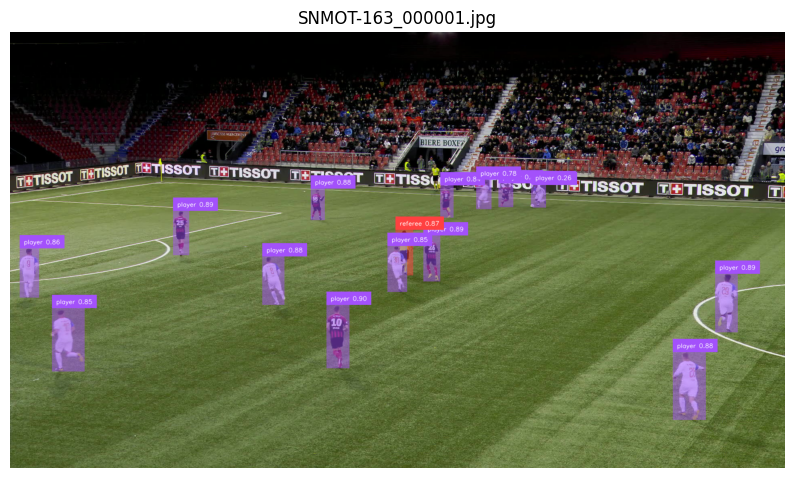

In [18]:
img_path = frame_paths[0]
print("Inference on:", img_path.name)

result = model(str(img_path), imgsz=640, device=device, verbose=False)[0]

detections = sv.Detections.from_ultralytics(result)

labels = [
    f"{names[int(cls_id)]} {conf:.2f}"
    for cls_id, conf in zip(detections.class_id, detections.confidence)
]

image_bgr = cv2.imread(str(img_path))

color_annotator = sv.ColorAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_bgr = color_annotator.annotate(
    scene=image_bgr.copy(),
    detections=detections
)
annotated_bgr = label_annotator.annotate(
    scene=annotated_bgr,
    detections=detections,
    labels=labels
)

annotated_rgb = cv2.cvtColor(annotated_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(annotated_rgb)
plt.axis("off")
plt.title(img_path.name)
plt.show()

# Con supervision

In [19]:

FPS = 25 # Esta en los metadatos

tracker = sv.ByteTrack(frame_rate=FPS)

bounding_box_annotator = sv.ColorAnnotator()
label_annotator = sv.LabelAnnotator()

video_out_path = VIDEO_OUT_DIR / f"SNMOT-{CLIP_ID}_tracking.mp4"
print("Output video:", video_out_path)

Output video: ../../videos/SNMOT-163_tracking.mp4


In [20]:
first_frame_bgr = cv2.imread(str(frame_paths[0]))
h, w = first_frame_bgr.shape[:2]

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(str(video_out_path), fourcc, FPS, (w, h))

for img_path in tqdm(frame_paths, desc=f"Tracking clip {CLIP_ID}"):
    
    frame_bgr = cv2.imread(str(img_path))

    # detección con YOLO en este frame
    result = model(frame_bgr, imgsz=640, device=device, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(result)

    # OPCIONAL: filtrar solo jugadores si tu clase "player" es, por ejemplo, la 0
    # player_mask = detections.class_id == 0
    # detections = detections[player_mask]

    # actualizar tracker (asigna tracker_id consistentes en el tiempo)
    detections = tracker.update_with_detections(detections)

    # labels con el ID de tracking para cada BBOX
    labels = [f"#{int(tracker_id)}" for tracker_id in detections.tracker_id]

    # dibujar bounding boxes + IDs
    annotated_frame = bounding_box_annotator.annotate(
        scene=frame_bgr.copy(),
        detections=detections,
    )
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels,
    )

    writer.write(annotated_frame)

writer.release()
print("Saved video to:", video_out_path)

Tracking clip 163:   1%|          | 6/750 [00:00<00:53, 13.79it/s]

Tracking clip 163: 100%|██████████| 750/750 [00:44<00:00, 16.92it/s]

Saved video to: ../../videos/SNMOT-163_tracking.mp4


## Con SAM

**Para usar SAM, tienen que correr esto**

```
uv pip install -q git+https://github.com/facebookresearch/segment-anything-2.git

wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

```

(Pesa lo suyo)

In [21]:
from sam2.build_sam import build_sam2_camera_predictor

class SAM2Tracker:
    def __init__(self, predictor):
        self.predictor = predictor
        self._prompted = False

    def prompt_first_frame(self, frame: np.ndarray, detections: sv.Detections):
        if len(detections) == 0:
            raise ValueError("detections must contain at least one box")
        
        # Assign tracker_ids if missing
        if detections.tracker_id is None:
            detections.tracker_id = list(range(1, len(detections) + 1))

        with torch.inference_mode(), torch.autocast("cuda", dtype=torch.float16):
            
            self.predictor.load_first_frame(frame)
            
            for xyxy, obj_id in zip(detections.xyxy, detections.tracker_id):
                bbox = np.asarray([xyxy], dtype=np.float32)
                # Add box prompt for the object
                self.predictor.add_new_prompt(
                    frame_idx=0,
                    obj_id=int(obj_id),
                    bbox=bbox,
                )
        self._prompted = True

    def propagate(self, frame: np.ndarray) -> sv.Detections:
        if not self._prompted:
            raise RuntimeError("Call prompt_first_frame before propagate")

        with torch.inference_mode(), torch.autocast("cuda", dtype=torch.float16):
            # Track returns: (obj_ids, mask_logits)
            tracker_ids, mask_logits = self.predictor.track(frame)

        if len(tracker_ids) == 0:
            return sv.Detections.empty()

        tracker_ids = np.asarray(tracker_ids, dtype=np.int32)
        masks = (mask_logits > 0.0).cpu().numpy()
        masks = np.squeeze(masks, axis=1).astype(bool) # (N, 1, H, W) -> (N, H, W)

        # Handle single object case where dim might be lost
        if masks.ndim == 2:
            masks = masks[None, ...]

        # Filter messy segments
        clean_masks = []
        for mask in masks:
            # This helper removes small disconnected regions
            clean_masks.append(sv.filter_segments_by_distance(mask, relative_distance=0.05, mode="edge"))
        
        masks = np.array(clean_masks)
        xyxy = sv.mask_to_xyxy(masks=masks) # Update boxes based on new mask shape
        
        return sv.Detections(
            xyxy=xyxy, 
            mask=masks, 
            tracker_id=tracker_ids
        )

In [32]:
SAM2_CHECKPOINT = "../../segment-anything-2-real-time/checkpoints/sam2.1_hiera_large.pt"
SAM2_CONFIG = "sam2.1_hiera_l.yaml"
print("Loading models...")

predictor = build_sam2_camera_predictor(SAM2_CONFIG, SAM2_CHECKPOINT, device=DEVICE)
tracker = SAM2Tracker(predictor)

frame_0 = cv2.imread(str(frame_paths[0]))

results = model(frame_0, verbose=False)[0]

valid_indices = [i for i, cls in enumerate(results.boxes.cls) if int(cls) in [0, 1, 2]]
initial_detections = sv.Detections.from_ultralytics(results)
initial_detections = initial_detections[valid_indices]



print(f"Initializing tracker with {len(initial_detections)} objects...")
tracker.prompt_first_frame(frame_0, initial_detections)

# Create a map to remember class IDs (SAM2 only tracks Object IDs)
id_to_class_map = {
    tid: cid 
    for tid, cid in zip(initial_detections.tracker_id, initial_detections.class_id)
}

Loading models...
Initializing tracker with 17 objects...
Initializing tracker with 17 objects...


In [ ]:
VIDEO_OUT_DIR = Path("../../videos")
VIDEO_OUT_DIR.mkdir(exist_ok=True)
OUTPUT_PATH = VIDEO_OUT_DIR / f"{CLIP_ID}_sam2_realtime.mp4"

height, width = frame_0.shape[:2]
video_info = sv.VideoInfo(width=width, height=height, fps=25)
mask_annotator = sv.MaskAnnotator(opacity=0.6)
box_annotator = sv.BoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator()


with sv.VideoSink(str(OUTPUT_PATH), video_info=video_info) as sink:
    
    for i, img_path in enumerate(tqdm(frame_paths, desc=f"Tracking clip {CLIP_ID} with SAM2")):
        frame = cv2.imread(str(img_path))

        if i == 0:
            annotated = mask_annotator.annotate(frame.copy(), initial_detections)
            annotated = box_annotator.annotate(annotated, initial_detections)
            sink.write_frame(annotated)
            continue
            
        detections = tracker.propagate(frame)
        
        # Recover Class IDs from our map
        if len(detections) > 0:
            recovered_classes = [id_to_class_map.get(tid, 0) for tid in detections.tracker_id]
            detections.class_id = np.array(recovered_classes)

            # Annotate
            annotated = mask_annotator.annotate(frame.copy(), detections)
            annotated = box_annotator.annotate(annotated, detections)
            
            labels = [
                f"#{tid} {model.names[cid]}"
                for tid, cid in zip(detections.tracker_id, detections.class_id)
            ]
            annotated = label_annotator.annotate(annotated, detections, labels=labels)
        else:
            annotated = frame

        sink.write_frame(annotated)

print(f"Video saved: {OUTPUT_PATH}")

Tracking clip 163 with SAM2: 100%|██████████| 750/750 [13:54<00:00,  1.11s/it]

Video saved: videos/163_sam2_realtime.mp4
